### Questions 
- nb de données != multiple de 24 ?
- date / date & heure de comptage pas redondant ? 
- qu'est-ce que la variable *filename* ? Nom du fichier depuis lequel on a importé les données ? (il n'y a que champs élysées & convention) 
- idem *etat de l'arc*

### Infos :
- *filename* plus utile

### TODO :
- [ ] faire son propre minmax scaler
- [x] List variables that need to be predicted
- [x] Combine data of all 3 arcs
- [ ] Make fction that displays one example
- [ ] Make fction that predicts for one week
- [ ] Sort by to predict or not
- [ ] one hot encode string variables (ex: moon phases)
- encode dates : ideas :
    - Time since 1970 (continuous) ? **not sure**
    - Day of year in [1, 365] (categorical)
    - Month of year in [1, 12] (categorical)
    - Day of week in [1, 7] (categorical)
    - Is weekend (binary indicator)
    - Is holiday (binary indicator)
    - etc.

## imports

In [1]:
from utils import load_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import ipywidgets as ipw
import tensorflow as tf

## Load Data

Index(['Date et heure de comptage', 'champs-elysees_Débit horaire',
       'champs-elysees_Taux d'occupation', 'champs-elysees_Etat trafic',
       'champs-elysees_Etat arc', 'convention_Débit horaire',
       'convention_Taux d'occupation', 'convention_Etat trafic',
       'convention_Etat arc', 'sts_Débit horaire', 'sts_Taux d'occupation',
       'sts_Etat trafic', 'sts_Etat arc', 'filename', 'Date',
       'Jour de la semaine_0', 'Jour de la semaine_1', 'Jour de la semaine_2',
       'Jour de la semaine_3', 'Jour de la semaine_4', 'Jour de la semaine_5',
       'Jour de la semaine_6', 'Etat du confinement', 'Couvre-feu',
       'Jour férié', 'Vacances scolaires',
       'Date des prochaines vacances scolaires',
       'Temps avant les prochaines vacances scolaires', 'tempC',
       'windspeedKmph', 'winddirDegree', 'weatherCode', 'precipMM', 'humidity',
       'visibility', 'pressure', 'cloudcover', 'HeatIndexC', 'DewPointC',
       'WindChillC', 'WindGustKmph', 'FeelsLikeC', 'hourl

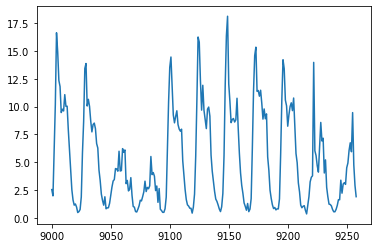

In [2]:
train_df = load_df("data\\df_concat_train.pkl")
print(train_df.columns)
train_df["champs-elysees_Taux d'occupation"][9000:].plot()

## Clean the data

In [22]:
def convert_types(df):
#     corrected_df = df.astype({: "float64"})
    return corrected_df


sorted_train_df = train_df

# drop unnecessary variables
features_to_drop = ['filename', 'Date', 'Date et heure de comptage']
# temporary drop all strings and datetime features
features_to_drop += ['moon_phase', 'champs-elysees_Etat arc', 'convention_Etat arc', 'sts_Etat arc', "Date des prochaines vacances scolaires", "Temps avant les prochaines vacances scolaires", "sunrise", "sunset"]
clean_train_df = train_df.drop(features_to_drop, axis=1)
# cc_train_df = convert_types(clean_train_df)

features_to_predict = ['champs-elysees_Débit horaire', "champs-elysees_Taux d'occupation", 'champs-elysees_Etat trafic','convention_Débit horaire',"convention_Taux d'occupation", "convention_Etat trafic", 'sts_Débit horaire', "sts_Taux d'occupation", 'sts_Etat trafic','tempC','windspeedKmph', 'winddirDegree', 'weatherCode', 'precipMM', 'humidity','visibility', 'pressure', 'cloudcover', 'HeatIndexC', 'DewPointC','WindChillC', 'WindGustKmph', 'FeelsLikeC', 'daily_uvIndex', 'maxtempC','mintempC', 'avgtempC', 'totalSnow_cm', 'sunHour', 'hourly_uvIndex', 'moon_illumination']
features_not_to_predict = [f for f in clean_train_df.columns if f not in features_to_predict]

nb_features = clean_train_df.shape[1]
nb_to_predict = len(features_to_predict)
nb_examples = clean_train_df.shape[0]
print("nb features : ", nb_features)
print("nb to predict : ", nb_to_predict)
print("nb examples : ", nb_examples)


# reorder columns to have those to predict first, the the others
new_index = features_to_predict + features_not_to_predict
reordered_train_df = clean_train_df.reindex(new_index, axis=1)
# print(reordered_train_df.columns)


def generate_table(df):
    print("| indice | Nom       | Type | à prédire |")
    print("| :-: | :-- | :-- | :-: |")
    
    type_corresp = {"uint8":"entier", "int64":"entier", "bool": "booléen", "float64": "flottant", "datetime64[ns]": "datetime", "object": "chaîne de caractère", "timedelta64[ns]": "timedelta"}
    
    for indice, infos in enumerate(zip(df.columns, df.dtypes)):
        x, y = infos
        if str(x) in features_to_predict:
            print("|", indice,"|", x, "|", type_corresp[str(y)], "|",'<span style="color:green">oui</span>', "|")
        else:
            print("|", indice, "|", x, "|", type_corresp[str(y)], "|",'<span style="color:red">non</span>', "|")
# generate_table(reordered_train_df)


nb features :  43
nb to predict :  31
nb examples :  9259


In [26]:
reordered_train_df.to_numpy().shape

(9259, 43)

### Variables info

| indice | Nom       | Type | à prédire |
| :-: | :-- | :-- | :-: |
| 0 | champs-elysees_Débit horaire | flottant | <span style="color:green">oui</span> |
| 1 | champs-elysees_Taux d'occupation | flottant | <span style="color:green">oui</span> |
| 2 | champs-elysees_Etat trafic | entier | <span style="color:green">oui</span> |
| 3 | convention_Débit horaire | flottant | <span style="color:green">oui</span> |
| 4 | convention_Taux d'occupation | flottant | <span style="color:green">oui</span> |
| 5 | convention_Etat trafic | entier | <span style="color:green">oui</span> |
| 6 | sts_Débit horaire | flottant | <span style="color:green">oui</span> |
| 7 | sts_Taux d'occupation | flottant | <span style="color:green">oui</span> |
| 8 | sts_Etat trafic | entier | <span style="color:green">oui</span> |
| 9 | tempC | entier | <span style="color:green">oui</span> |
| 10 | windspeedKmph | entier | <span style="color:green">oui</span> |
| 11 | winddirDegree | entier | <span style="color:green">oui</span> |
| 12 | weatherCode | entier | <span style="color:green">oui</span> |
| 13 | precipMM | flottant | <span style="color:green">oui</span> |
| 14 | humidity | entier | <span style="color:green">oui</span> |
| 15 | visibility | entier | <span style="color:green">oui</span> |
| 16 | pressure | entier | <span style="color:green">oui</span> |
| 17 | cloudcover | entier | <span style="color:green">oui</span> |
| 18 | HeatIndexC | entier | <span style="color:green">oui</span> |
| 19 | DewPointC | entier | <span style="color:green">oui</span> |
| 20 | WindChillC | entier | <span style="color:green">oui</span> |
| 21 | WindGustKmph | entier | <span style="color:green">oui</span> |
| 22 | FeelsLikeC | entier | <span style="color:green">oui</span> |
| 23 | daily_uvIndex | entier | <span style="color:green">oui</span> |
| 24 | maxtempC | entier | <span style="color:green">oui</span> |
| 25 | mintempC | entier | <span style="color:green">oui</span> |
| 26 | avgtempC | entier | <span style="color:green">oui</span> |
| 27 | totalSnow_cm | flottant | <span style="color:green">oui</span> |
| 28 | sunHour | flottant | <span style="color:green">oui</span> |
| 29 | hourly_uvIndex | entier | <span style="color:green">oui</span> |
| 30 | moon_illumination | entier | <span style="color:green">oui</span> |
| 31 | Jour de la semaine_0 | entier | <span style="color:red">non</span> |
| 32 | Jour de la semaine_1 | entier | <span style="color:red">non</span> |
| 33 | Jour de la semaine_2 | entier | <span style="color:red">non</span> |
| 34 | Jour de la semaine_3 | entier | <span style="color:red">non</span> |
| 35 | Jour de la semaine_4 | entier | <span style="color:red">non</span> |
| 36 | Jour de la semaine_5 | entier | <span style="color:red">non</span> |
| 37 | Jour de la semaine_6 | entier | <span style="color:red">non</span> |
| 38 | Etat du confinement | entier | <span style="color:red">non</span> |
| 39 | Couvre-feu | booléen | <span style="color:red">non</span> |
| 40 | Jour férié | booléen | <span style="color:red">non</span> |
| 41 | Vacances scolaires | booléen | <span style="color:red">non</span> |
| 42 | Journée | booléen | <span style="color:red">non</span> |

## Prepare data

#### Input data :
les points de données des instants `t-n` à `t`
- débit horaire [int]
- Taux d'occupation [float]
- météo : température, couverture nuageuse, ...

#### Output data :
for each arc (x3) instant `t+1`:
- débit horaire [int]
- Taux d'occupation [float]

<br/>
And all data that needs to be predicted 

In [127]:
## Vérifier les  dimensions... 

def get_X_y(df, nb_steps=24):
    """ returns the X and y vectors from dataframe 
        steps : nb of datapoints in each Xi
    """ 
    nb_train_ex = nb_examples - (nb_steps + 1) + 1 # 1 in () : the y 
    print("nb train examples : ",nb_train_ex)
    print("nb features : ", nb_features)
    print("nb to predict : ", nb_to_predict)
    
    X = np.empty((nb_train_ex, nb_steps, nb_features))
    y = np.empty((nb_train_ex, nb_to_predict))
    for k_start in range(nb_train_ex):  
        X_k = clean_train_df.loc[k_start:k_start + nb_steps-1].to_numpy().reshape(nb_steps, nb_features)
        y_k = df[features_to_predict].iloc[k_start + nb_steps]

        example_id = k_start

        X[example_id, :, :] = X_k
        y[example_id, :] = y_k
#     X_tensor = tf.convert_to_tensor(X)
#     y_tensor = tf.convert_to_tensor(y)
    return X, y


X, y = get_X_y(reordered_train_df)

# from sklearn.preprocessing import MinMaxScaler
# # define data
# print(X)
# # define min max scaler
# scaler = MinMaxScaler()
# # transform data
# scaled = scaler.fit_transform(X)
# print(scaled)
# print(X.shape)

    
def display_predicted(X, y_pred):
    """ hey """
    pass

# print(clean_train_df[["Journée", "moon_illumination"]].iloc[24])
# fonction qui affiche à partir de Xi et yi (ou y_predi) les débits horaires et taux d'occupation

nb train examples :  9235
nb features :  43
nb to predict :  31


### Scale the data

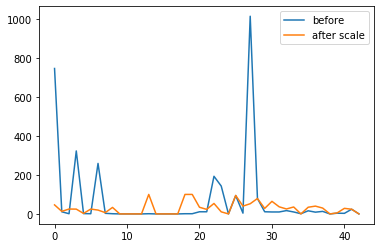

In [128]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scalers = {}
    s_X = np.zeros_like(X)
    for i in range(X.shape[2]):
        scalers[i] = MinMaxScaler()
        s_X[:, :, i] = scalers[i].fit_transform(X[:, :, i]) 
    return s_X, scalers

s_X, scalers = scale(X)
plt.plot(np.abs(X[0,0]), label="before")
plt.plot(np.abs(s_X[0,0])*100, label="after scale")
plt.legend()

## First model

In [129]:
### 
def model_1(nb_steps=24, show_summary=False):
    input_shape = (nb_steps, nb_features)
    print("input shape : ", input_shape)
    
    model = models.Sequential()

    model.add(layers.Conv1D(256, kernel_size=(3,),
                        input_shape=input_shape, activation="relu"))
    model.add(layers.MaxPooling1D(3))
    model.add(layers.Dropout(0.2))

#     model.add(layers.Conv1D(128, kernel_size=(3,), activation="relu"))
#     model.add(layers.MaxPooling1D(3))
#     model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(nb_to_predict, activation="linear"))
    
    if show_summary:
        model.summary()
        
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    return model

# test
cnn_model_1 = model_1(show_summary=True) 

input shape :  (24, 43)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 22, 256)           33280     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 256)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               459008    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (

In [130]:
# attention : avec un modèle erronné, on arrivait à mae = 10, 
cnn_model_1.fit(s_X, y, batch_size=32, epochs=100, verbose=1)

# resultats (100 epochs):
# 1 couche conv, 24 time steps : 9.4
# 2 couche conv, 48 t.s. : 10+
# 1 couche conv, 24 ts, conv 256, fully conn 256 : 8.9

# now best : 7.1 (100 epochs) (and 6.1 after 200 epochs)

Epoch 1/100
289/289 [==============================] - 2s 4ms/step - loss: 26541.1282 - mae: 60.8235
Epoch 2/100
289/289 [==============================] - 1s 4ms/step - loss: 4140.2806 - mae: 25.4220
Epoch 3/100
289/289 [==============================] - 1s 4ms/step - loss: 3036.7638 - mae: 21.8604
Epoch 4/100
289/289 [==============================] - 1s 4ms/step - loss: 2538.7480 - mae: 20.0333
Epoch 5/100
289/289 [==============================] - 1s 4ms/step - loss: 2140.2278 - mae: 18.3073
Epoch 6/100
289/289 [==============================] - 1s 4ms/step - loss: 1886.8036 - mae: 16.9676
Epoch 7/100
289/289 [==============================] - 1s 4ms/step - loss: 1843.5416 - mae: 16.6858
Epoch 8/100
289/289 [==============================] - 1s 4ms/step - loss: 1678.3415 - mae: 16.1035
Epoch 9/100
289/289 [==============================] - 1s 5ms/step - loss: 1590.7010 - mae: 15.5392
Epoch 10/100
289/289 [==============================] - 1s 4ms/step - loss: 1538.5929 - mae: 15.116

289/289 [==============================] - 1s 5ms/step - loss: 576.2880 - mae: 9.0851
Epoch 83/100
289/289 [==============================] - 1s 5ms/step - loss: 520.8358 - mae: 8.5836
Epoch 84/100
289/289 [==============================] - 1s 5ms/step - loss: 563.4121 - mae: 8.8474
Epoch 85/100
289/289 [==============================] - 1s 5ms/step - loss: 545.7017 - mae: 8.6884
Epoch 86/100
289/289 [==============================] - 1s 5ms/step - loss: 542.9682 - mae: 8.6482
Epoch 87/100
289/289 [==============================] - 1s 5ms/step - loss: 552.3339 - mae: 8.7339
Epoch 88/100
289/289 [==============================] - 1s 5ms/step - loss: 539.1914 - mae: 8.7032
Epoch 89/100
289/289 [==============================] - 1s 5ms/step - loss: 536.3239 - mae: 8.7334
Epoch 90/100
289/289 [==============================] - 1s 5ms/step - loss: 532.3608 - mae: 8.6300
Epoch 91/100
289/289 [==============================] - 1s 5ms/step - loss: 526.5852 - mae: 8.6019
Epoch 92/100
289/289 [=

## Evaluate model

### First : predict one point (=1h)

681655.7


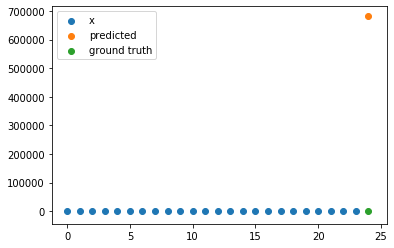

In [131]:
# plt.plot(y[0:24,0])

def show_one_pred(model, s_X, y, i):
    """ computes rmse & shows the predicted point """
    y_pred = model.predict(s_X[i].reshape(1, 24, nb_features))
    print(y_pred[0][0])
    abscissa = list(range(24))
    plt.scatter(abscissa, y[i:i+24,0], label="x")
    plt.scatter([i+24], [y_pred[0][0]], label="predicted")
    plt.scatter([i+24], y[i+24,0], label="ground truth")
    plt.legend()
    
show_one_pred(cnn_model_1, X, y, 0)

### Then : predict one week

In [126]:
def predict_one_week(model, df):
    """ predicts y for 24*7 = 168 hours 
        first, we will only return the predicted y for <champs-elysees_Débit horaire>
        
        steps : 
            - get the 24 first values of each feature, put it in a np array
            - predict the 25th for features_to_predict
            - store <champs-elysees_Débit horaire> in a list
            - create one complete line with predicted and not predicted
            - add this line to the examples
            - take the 24 last values 
    """
    nb_predict = 24 * 7 # change to parameters
    pred_feat_index = features_to_predict.index('champs-elysees_Débit horaire') # index_of_feature_to_predict
    
    # array qui contiendra les prédictions des y
    predicted_y = np.empty(nb_predict)
    # array qui contiendra les X
    X_24 = np.empty((24 + nb_predict, nb_features))
    # on le remplit avec les premieres valeurs
    first_24_X = df.loc[0:23].to_numpy().reshape(24, nb_features)
    X_24[0:24, :] = first_24_X
    
    for i in range(nb_predict):
        
        # get the inputs
        next_24_X = X_24[i:24 + i, :].reshape(1, 24, nb_features)
        # scale the inputs
        for k in range(nb_features):
            next_24_X[:, :, k] = scalers[k].transform(next_24_X[:, :, k])
        # predict the 24+i th value
        f_y_pred = model.predict(next_24_X)
        # store <champs-elysees_Débit horaire> in a list
        predicted_y[i] = f_y_pred[0][pred_feat_index]
        # create one complete line with predicted and not predicted
        # take 25th line
        next_line = df.loc[24 + i].to_numpy() #.reshape(24, nb_features)
        # replace predicted values 
        next_line[0:nb_to_predict] = f_y_pred
        # add to the X_24 array
        X_24[24 + i,:] = next_line
    
    return predicted_y


# test 
pred_y = predict_one_week(cnn_model_1, reordered_train_df)
ground_truth_y = reordered_train_df['champs-elysees_Débit horaire'][24:24 + 24 * 7]
# print(pred_y)

ValueError: Input contains infinity or a value too large for dtype('float64').

In [ ]:
def display_comparison(true_y, pred_y, nb_steps):
    abscissa = list(range(nb_steps))
    plt.plot(abscissa, pred_y[:nb_steps], label="predicted")
    plt.plot(abscissa, ground_truth_y[:nb_steps], label="ground truth")
    plt.legend()
display_comparison(ground_truth_y, pred_y, 30)